In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import json
import pickle
import glob
from collections import defaultdict
import torch
from pymatgen import core as mg
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
import tqdm
import os
import joblib
import random
from uncertainties import ufloat
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from modules.function import pymatgen_comp, data_generator_vec, check_cuda, get_metrics
from modules.encoder import Encoder1D, EncoderDNN
from modules.representation_schemes import get_vectorized_featues, get_atomic_number_features, get_pettifor_features, get_modified_pettifor_features, get_random_features, get_random_features_dense, random_order

In [3]:
random.seed(0)
torch.manual_seed(0)

In [4]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
alternate_orders_file = 'dataset/alternate_orders.pkl'
with open(alternate_orders_file,'rb') as fid:
    alternate_order_dict = pickle.load(fid)
pettifor_order = alternate_order_dict['pettifor']
modified_pettifor_order = alternate_order_dict['modified_pettifor']
random_order = random_order

In [6]:
gfa_dataset_file = 'gfa_dataset.txt'
z_row_column_file = 'Z_row_column.txt'
element_property_file = 'element_property.txt'
common_path = "Files_from_GTDL_paper/{}" 
gfa_dataset = pickle.load(open(common_path.format(gfa_dataset_file), 'rb'))  
RC = pickle.load(open(common_path.format(z_row_column_file), 'rb')) 
new_index=[int(i[4]) for i in RC]#new order 
Z_row_column = pickle.load(open(common_path.format(z_row_column_file), 'rb'))
[property_name_list,property_list,element_name,_]=pickle.load(open(common_path.format(element_property_file), 'rb'))

In [7]:
import re

to_discard = ['Rf','Db','Sg','Bh','Hs']

def alt_read_gfa_dataset(dataset = gfa_dataset):
    str_comp = []
    Y = []
    p = []
    for i in  gfa_dataset:
        p.extend([0,1])
        gfa=re.findall('\[[a-c]?\]',i)[0]
        tx1_element=re.findall('[A-Z][a-z]?', i)#[B, Fe, P,No]
        tx2_temp=re.findall('\$_{[0-9.]+}\$', i)#[$_{[50]}$, ] [50 30 20]
        tx2_value=[float(re.findall('[0-9.]+', i_tx2)[0]) for i_tx2 in tx2_temp]
        test = ''.join([x+str(y) for x,y in zip(tx1_element,tx2_value)])
        if gfa=='[c]':
            y= [0,0]
        if gfa=='[b]':
             y = [1,0]
        if gfa == '[a]': 
            y = [1,1]
        if len(set(tx1_element).intersection(set(to_discard))) == 0:
            str_comp.extend([test]*2)
            Y.extend(y)
    return pymatgen_comp(str_comp),Y, p

In [8]:
saveloc = 'saved_models/Encoders'
if not os.path.exists(saveloc):
    os.makedirs(f'{saveloc}')
with open('misc/kfold.pkl','rb') as fid:
    fold_dict = pickle.load(fid)
folds = len(list(fold_dict.keys()))

In [9]:
if os.path.exists('results/representation_stats.json'):
    with open('results/representation_stats.json','rb') as fid:
        data_file = json.load(fid)
else:
    print('File does not exist!')

In [13]:
comp_gfa, y_gfa,p = alt_read_gfa_dataset()
#types = ['atomic','pettifor','mod_pettifor','random','dense']
types = ['mod_pettifor','random']
order_dict = {}
sup_metrics_dict = {}
y_all = np.array(y_gfa).reshape(-1,1).astype('float32')
p_all = np.array(p).reshape(-1,1).astype('float32')
for i,k in enumerate(types):
    metrics_list = {}
    print('Representation : {}'.format(k))
    if k == 'atomic':
        comp, at_order  = get_atomic_number_features(comp_gfa)
        order_dict['atomic'] = at_order
    elif k == 'pettifor':
        comp, _  = get_pettifor_features(comp_gfa)
        order_dict['pettifor'] = pettifor_order
    elif k == 'mod_pettifor':
        comp, _  = get_modified_pettifor_features(comp_gfa)
        order_dict['mod_pettifor'] = modified_pettifor_order
    elif k == 'random':
        comp,_ = get_random_features(comp_gfa, random_order)
        order_dict['random'] = random_order
    elif k == 'dense':
        comp,_ = get_random_features_dense(comp_gfa, random_order)
        order_dict['random'] = random_order
    X_all = comp.astype('float32')
    
    for fold in range(folds):
        print('Fold {}'.format(fold))
        i_tr= fold_dict[fold]['train_inds']
        i_te= fold_dict[fold]['test_inds']
        X_train, X_test = X_all[i_tr], X_all[i_te]
        y_train, y_test = y_all[i_tr], y_all[i_te]
        p_train, p_test = p_all[i_tr], p_all[i_te]
        batch = 64
        Xy = [(X_train[i],y_train[i],p_train[i]) for i in range(len(y_train))]
        train_loader = DataLoader(Xy, batch_size = batch , shuffle=True)
        if k!= 'dense':
            encoder1D = Encoder1D(1,1)
        else:
            encoder1D = EncoderDNN(X_train.shape[-1],3,42,1)
        e_optimizer = optim.Adam(encoder1D.parameters(),lr = 2e-4)
        num_iterations = 2000
        cuda = check_cuda()
        if cuda:
            encoder1D = encoder1D.cuda()
        log_interval = int(5e2)
        for iter in tqdm.notebook.tqdm(range(num_iterations)):
            train_loss = 0.0
            for data in train_loader:
                X,y,p = data
                if cuda:
                    X = X.cuda()
                    y = y.cuda()
                    p = p.cuda()
                e_optimizer.zero_grad()
                target = encoder1D(X,p)
                if cuda:
                    target = target.cuda()
                e_error = torch.nn.BCELoss()(target,y)
                e_error.backward(retain_graph=True)
                e_optimizer.step()
                train_loss += e_error.cpu().item()
            if iter == 0 or (iter + 1) % log_interval == 0:  
                print('Epoch : {}, Loss : {}'.format(iter+1,train_loss))
        spec_saveloc = os.path.join(saveloc,k)
        if not os.path.exists(spec_saveloc):
            os.makedirs(f'{spec_saveloc}')
        joblib.dump(encoder1D,os.path.join(spec_saveloc,'Encoder1D_{}_fold{}.pt'.format(k,fold)))
        if X_test.dtype != torch.float32:
            X_test = torch.from_numpy(X_test)
        if p_test.dtype != torch.float32:
            p_test = torch.from_numpy(p_test)
        if cuda:
            X_test =  X_test.cuda()
            p_test = p_test.cuda()
        y_predict = (encoder1D(X_test,p_test)).to('cpu').detach().numpy()
        metrics = get_metrics(y_test,np.round(y_predict))
        metrics_list[fold] = metrics
        print('accuracy : {},precision : {},recall : {},F1 : {}'.format(metrics[0],metrics[1],metrics[2],metrics[3]))
    sup_metrics_dict[k] = metrics_list
    updated_file = data_file|sup_metrics_dict
    with open('results/representation_stats.json','w') as f:
        json.dump(updated_file,f)

Representation : mod_pettifor
Fold 0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.997124761343
Epoch : 500, Loss : 44.31302625872195
Epoch : 1000, Loss : 36.618306782096624
Epoch : 1500, Loss : 32.23338754661381
Epoch : 2000, Loss : 28.992148185148835
accuracy : 0.9492,precision : 0.949,recall : 0.9492,F1 : 0.9489
Fold 1


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.73948046565056
Epoch : 500, Loss : 45.13342610374093
Epoch : 1000, Loss : 37.79682997055352
Epoch : 1500, Loss : 32.988039871677756
Epoch : 2000, Loss : 30.34194364771247
accuracy : 0.9545,precision : 0.9556,recall : 0.9545,F1 : 0.9548
Fold 2


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.24989676475525
Epoch : 500, Loss : 40.285660937428474
Epoch : 1000, Loss : 34.21734282374382
Epoch : 1500, Loss : 30.39402286708355
Epoch : 2000, Loss : 27.638978770002723
accuracy : 0.9444,precision : 0.9441,recall : 0.9444,F1 : 0.9442
Fold 3


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 185.25969171524048
Epoch : 500, Loss : 46.32013286277652
Epoch : 1000, Loss : 37.688307674601674
Epoch : 1500, Loss : 32.88511062040925
Epoch : 2000, Loss : 29.633148286491632
accuracy : 0.9348,precision : 0.9354,recall : 0.9348,F1 : 0.9351
Fold 4


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.39516219496727
Epoch : 500, Loss : 46.1575542986393
Epoch : 1000, Loss : 37.88871372118592
Epoch : 1500, Loss : 33.246695471927524
Epoch : 2000, Loss : 31.205438947305083
accuracy : 0.9463,precision : 0.948,recall : 0.9463,F1 : 0.9468
Fold 5


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.31727200746536
Epoch : 500, Loss : 43.39103328809142
Epoch : 1000, Loss : 37.65545208379626
Epoch : 1500, Loss : 33.64896718598902
Epoch : 2000, Loss : 31.07921956293285
accuracy : 0.9459,precision : 0.947,recall : 0.9459,F1 : 0.9462
Fold 6


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 184.21085187792778
Epoch : 500, Loss : 42.24876484274864
Epoch : 1000, Loss : 35.485686376690865
Epoch : 1500, Loss : 32.48426077887416
Epoch : 2000, Loss : 29.64475983195007
accuracy : 0.9506,precision : 0.9512,recall : 0.9506,F1 : 0.9508
Fold 7


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.05093491077423
Epoch : 500, Loss : 42.773121766746044
Epoch : 1000, Loss : 35.045041639357805
Epoch : 1500, Loss : 31.32963703200221
Epoch : 2000, Loss : 28.319055393338203
accuracy : 0.9535,precision : 0.9538,recall : 0.9535,F1 : 0.9536
Fold 8


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.7276603281498
Epoch : 500, Loss : 45.81472922861576
Epoch : 1000, Loss : 37.547107733786106
Epoch : 1500, Loss : 33.20359028875828
Epoch : 2000, Loss : 30.414381997659802
accuracy : 0.955,precision : 0.9549,recall : 0.955,F1 : 0.9549
Fold 9


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.60839349031448
Epoch : 500, Loss : 47.19789568707347
Epoch : 1000, Loss : 37.835707772523165
Epoch : 1500, Loss : 32.85191204957664
Epoch : 2000, Loss : 30.25437216833234
accuracy : 0.9406,precision : 0.9402,recall : 0.9406,F1 : 0.9401
Representation : random
Fold 0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 186.8295509815216
Epoch : 500, Loss : 50.9417607486248
Epoch : 1000, Loss : 41.35565663874149
Epoch : 1500, Loss : 35.58691807463765
Epoch : 2000, Loss : 32.333315034396946
accuracy : 0.9415,precision : 0.9433,recall : 0.9415,F1 : 0.942
Fold 1


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 186.0861073434353
Epoch : 500, Loss : 54.23141510784626
Epoch : 1000, Loss : 44.33808686584234
Epoch : 1500, Loss : 39.56832420825958
Epoch : 2000, Loss : 34.8561887871474
accuracy : 0.9396,precision : 0.9397,recall : 0.9396,F1 : 0.9388
Fold 2


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 186.94245201349258
Epoch : 500, Loss : 51.797152638435364
Epoch : 1000, Loss : 41.455628883093596
Epoch : 1500, Loss : 36.43550281226635
Epoch : 2000, Loss : 32.980134127661586
accuracy : 0.9363,precision : 0.9359,recall : 0.9363,F1 : 0.9358
Fold 3


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 185.37481009960175
Epoch : 500, Loss : 46.444133039563894
Epoch : 1000, Loss : 36.84095998480916
Epoch : 1500, Loss : 32.51575689949095
Epoch : 2000, Loss : 28.17102501541376
accuracy : 0.9291,precision : 0.9286,recall : 0.9291,F1 : 0.9287
Fold 4


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 186.53930753469467
Epoch : 500, Loss : 54.1713310778141
Epoch : 1000, Loss : 44.37210022471845
Epoch : 1500, Loss : 38.686462465673685
Epoch : 2000, Loss : 33.71928973682225
accuracy : 0.9368,precision : 0.9368,recall : 0.9368,F1 : 0.9368
Fold 5


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 185.12012314796448
Epoch : 500, Loss : 48.07252990081906
Epoch : 1000, Loss : 39.14392378553748
Epoch : 1500, Loss : 33.231565453112125
Epoch : 2000, Loss : 30.57665092870593
accuracy : 0.9363,precision : 0.9364,recall : 0.9363,F1 : 0.9354
Fold 6


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 184.37504637241364
Epoch : 500, Loss : 50.309423703700304
Epoch : 1000, Loss : 39.5692647062242
Epoch : 1500, Loss : 34.71749028377235
Epoch : 2000, Loss : 30.805623000487685
accuracy : 0.9502,precision : 0.95,recall : 0.9502,F1 : 0.9499
Fold 7


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 186.1537243127823
Epoch : 500, Loss : 50.9988139718771
Epoch : 1000, Loss : 41.05166869610548
Epoch : 1500, Loss : 35.60792816616595
Epoch : 2000, Loss : 32.296660240739584
accuracy : 0.9521,precision : 0.9519,recall : 0.9521,F1 : 0.9518
Fold 8


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 185.7648901939392
Epoch : 500, Loss : 53.82452192157507
Epoch : 1000, Loss : 44.096055671572685
Epoch : 1500, Loss : 38.827472327277064
Epoch : 2000, Loss : 35.080506179481745
accuracy : 0.9454,precision : 0.9457,recall : 0.9454,F1 : 0.9455
Fold 9


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 184.47714626789093
Epoch : 500, Loss : 52.68816854804754
Epoch : 1000, Loss : 42.93741064891219
Epoch : 1500, Loss : 37.21925011277199
Epoch : 2000, Loss : 34.23794085904956
accuracy : 0.9334,precision : 0.9368,recall : 0.9334,F1 : 0.9342


In [14]:
for key in updated_file.keys():
    specific_dict = updated_file[key]
    col_names = ['Accuracy','Precision','Recall','F1 Score']
    stat_df = pd.DataFrame.from_dict(specific_dict,orient='index',columns=col_names)
    mean_stats, std_stats = stat_df.values.mean(axis=0), stat_df.values.std(axis=0)
    best_ind = np.argwhere(stat_df['F1 Score'].values == np.max(stat_df['F1 Score'])).item()
    vals = [ufloat(np.round(mean_stats[i],3), np.round(std_stats[i],3)) for i in range(len(mean_stats))]
    print('{} \nAccuracy : {}, \nPrecision : {}, \nRecall : {}, \nF1 Score : {}'.format(key,vals[0],vals[1],vals[2],vals[3]))

ptr 
Accuracy : 0.949+/-0.005, 
Precision : 0.950+/-0.005, 
Recall : 0.949+/-0.005, 
F1 Score : 0.949+/-0.005
atomic 
Accuracy : 0.950+/-0.005, 
Precision : 0.951+/-0.005, 
Recall : 0.950+/-0.005, 
F1 Score : 0.950+/-0.005
pettifor 
Accuracy : 0.945+/-0.008, 
Precision : 0.946+/-0.008, 
Recall : 0.945+/-0.008, 
F1 Score : 0.945+/-0.008
mod_pettifor 
Accuracy : 0.947+/-0.006, 
Precision : 0.948+/-0.006, 
Recall : 0.947+/-0.006, 
F1 Score : 0.948+/-0.006
random 
Accuracy : 0.940+/-0.007, 
Precision : 0.941+/-0.007, 
Recall : 0.940+/-0.007, 
F1 Score : 0.940+/-0.007
dense 
Accuracy : 0.947+/-0.006, 
Precision : 0.948+/-0.006, 
Recall : 0.947+/-0.006, 
F1 Score : 0.947+/-0.006


In [15]:
import shutil
best_model_loc = 'saved_models/best_models'
if not os.path.exists(best_model_loc):
    os.makedirs(f'{best_model_loc}')
for key in sup_metrics_dict.keys():
    col_names = ['Accuracy','Precision','Recall','F1 Score']
    stat_df = pd.DataFrame.from_dict(sup_metrics_dict[key],orient='index',columns=col_names)
    spec_saveloc = os.path.join(saveloc,key)
    best_ind = np.argwhere(stat_df['F1 Score'].values == np.max(stat_df['F1 Score'])).item()
    best_model_name = sorted(os.listdir(spec_saveloc))[best_ind]
    shutil.copy(os.path.join(spec_saveloc,best_model_name), os.path.join(best_model_loc,'1DEncoder_{}.pt'.format(key))) 

/tmp/ipykernel_288376/1543868786.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(data_file.keys(), rotation=45)
/tmp/ipykernel_288376/1543868786.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(data_file.keys(), rotation=45)
/tmp/ipykernel_288376/1543868786.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(data_file.keys(), rotation=45)
/tmp/ipykernel_288376/1543868786.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(data_file.keys(), rotation=45)


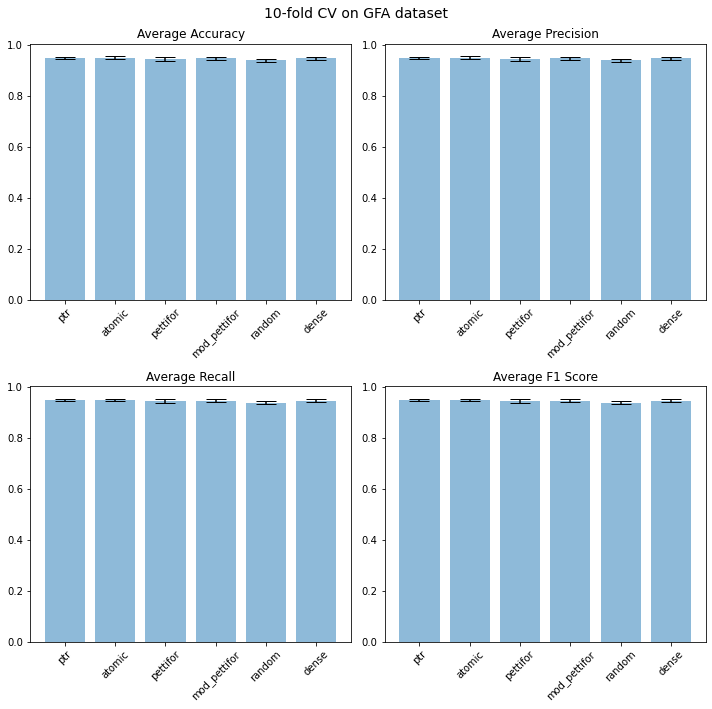

In [16]:
col_names = ['Accuracy','Precision','Recall','F1 Score']
with open('results/representation_stats.json','rb') as fid:
        data_file = json.load(fid)
mean_list = []
std_list = []
for i, k in enumerate(data_file.keys()):
        stat_arr = np.array(list(data_file[k].values()))
        mean_list.append(stat_arr.mean(axis=0))
        std_list.append(stat_arr.std(axis=0))
mean_list = np.array(mean_list).T
std_list = np.array(std_list).T
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.ravel()
for i, k in enumerate(col_names):
        ax[i].bar(data_file.keys(), mean_list[i], yerr = std_list[i],align='center', alpha=0.5, ecolor='black', capsize=10)
        ax[i].set_title('Average {}'.format(k))
        ax[i].set_xticklabels(data_file.keys(), rotation=45)

fig.suptitle('10-fold CV on GFA dataset', fontsize = 14)
plt.tight_layout()